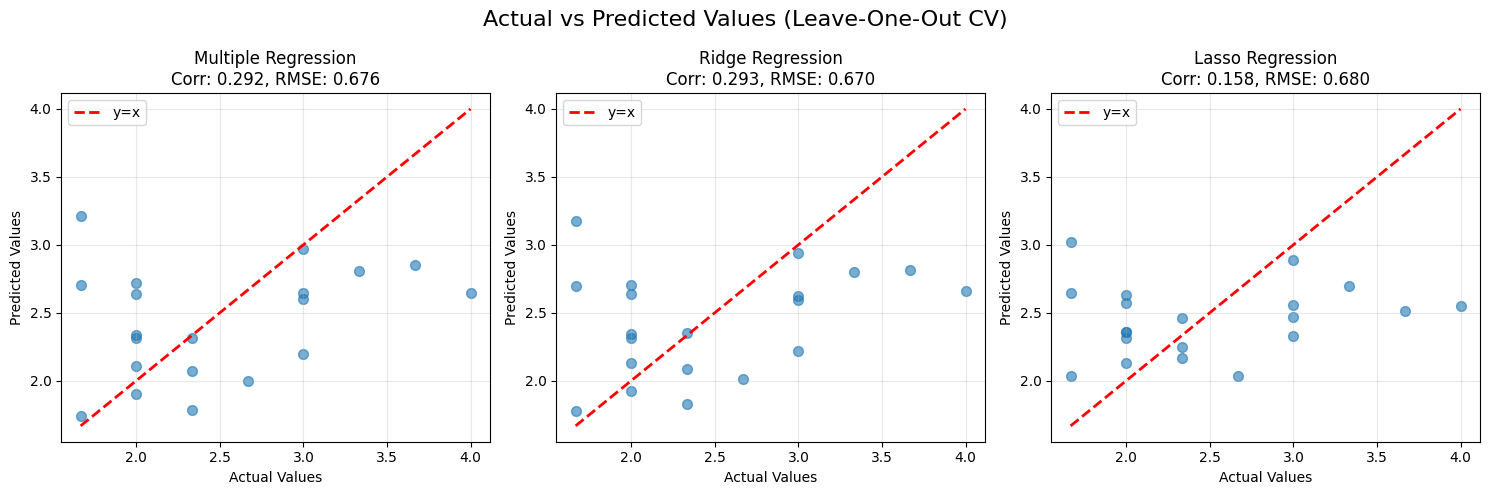

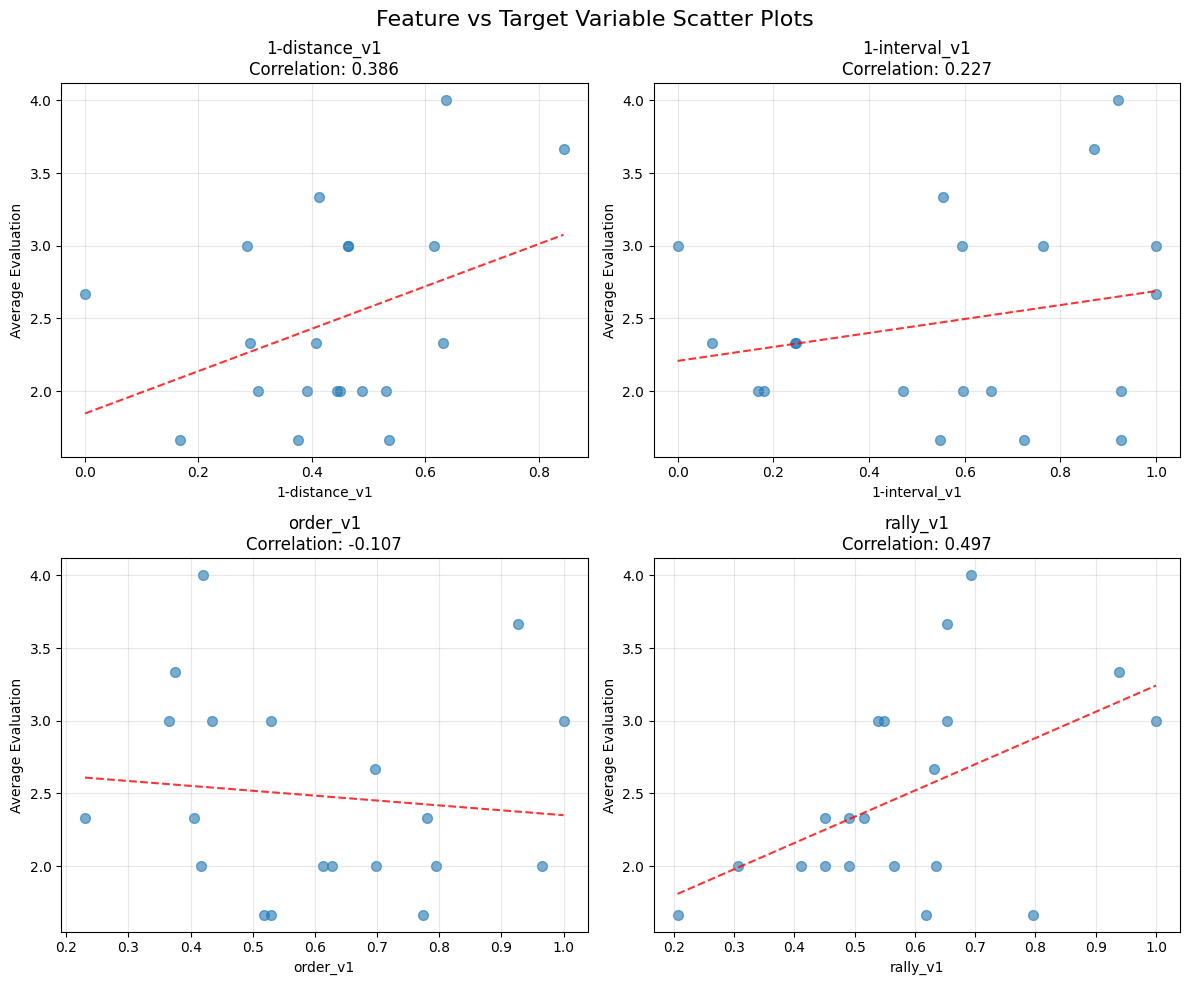

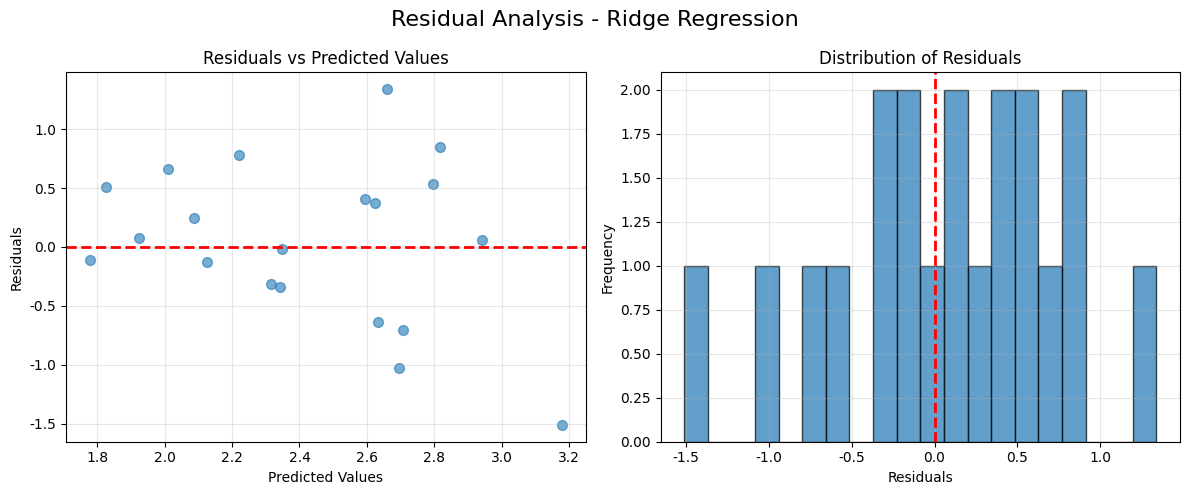

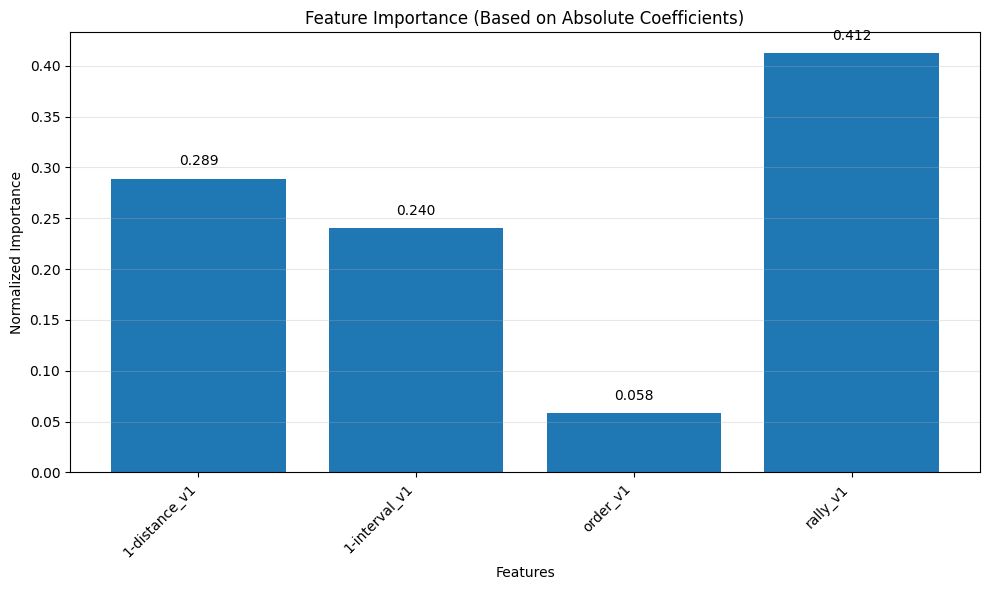

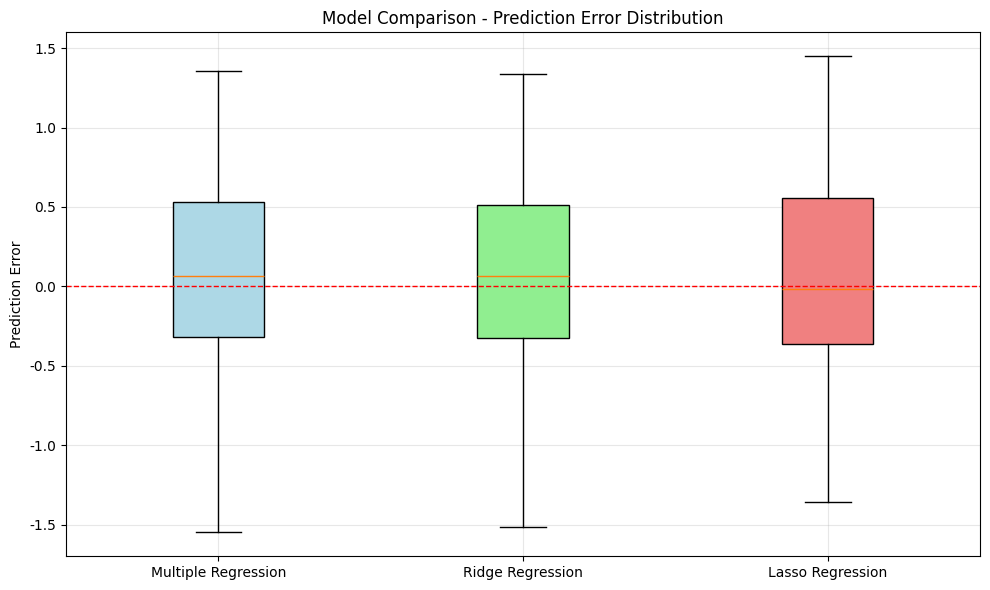


===== 散布図作成完了 =====
作成した図:
1. 実測値 vs 予測値の散布図（3モデル比較）
2. 各特徴量と目的変数の散布図
3. 残差分析（最良モデル）
4. 特徴量の重要度
5. モデル間の予測誤差比較


In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# CSVファイルを読み込み
df = pd.read_csv('../data/src/structural-features.csv')

# 特徴量と目的変数を分離
feature_columns = ['1-distance_v1', '1-interval_v1', 'order_v1', 'rally_v1']
X = df[feature_columns]
y = df['average_evaluation']

# Leave-One-Out交差検証の準備
loo = LeaveOneOut()
n_samples = len(X)

# 各モデルの結果を格納する辞書
results = {
    'Multiple Regression': {'predictions': [], 'model': LinearRegression()},
    'Ridge Regression': {'predictions': [], 'model': Ridge(alpha=1.0)},
    'Lasso Regression': {'predictions': [], 'model': Lasso(alpha=0.1)}
}

# 標準化のためのスケーラー
scaler = StandardScaler()

# Leave-One-Out交差検証の実行
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # データの標準化
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 各モデルで学習と予測
    for model_name, model_info in results.items():
        model = model_info['model']
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        model_info['predictions'].append(y_pred[0])

# 図1: 実測値 vs 予測値の散布図（3つのモデル）
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Actual vs Predicted Values (Leave-One-Out CV)', fontsize=16)

for idx, (model_name, model_info) in enumerate(results.items()):
    predictions = np.array(model_info['predictions'])
    ax = axes[idx]
    
    # 散布図
    ax.scatter(y, predictions, alpha=0.6, s=50)
    
    # 理想的な予測線（y=x）
    min_val = min(y.min(), predictions.min())
    max_val = max(y.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x')
    
    # 相関係数とRMSE
    correlation = np.corrcoef(y, predictions)[0, 1]
    rmse = np.sqrt(mean_squared_error(y, predictions))
    
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{model_name}\nCorr: {correlation:.3f}, RMSE: {rmse:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 図2: 各特徴量と目的変数の散布図
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Feature vs Target Variable Scatter Plots', fontsize=16)

for idx, feature in enumerate(feature_columns):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(X[feature], y, alpha=0.6, s=50)
    
    # 線形回帰線を追加
    z = np.polyfit(X[feature], y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(X[feature].min(), X[feature].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8)
    
    # 相関係数
    corr = np.corrcoef(X[feature], y)[0, 1]
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Average Evaluation')
    ax.set_title(f'{feature}\nCorrelation: {corr:.3f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 図3: 残差プロット（最良モデル）
best_model_name = min(results, key=lambda x: np.sqrt(mean_squared_error(y, results[x]['predictions'])))
best_predictions = np.array(results[best_model_name]['predictions'])
residuals = y - best_predictions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Residual Analysis - {best_model_name}', fontsize=16)

# 残差 vs 予測値
ax1.scatter(best_predictions, residuals, alpha=0.6, s=50)
ax1.axhline(y=0, color='r', linestyle='--', lw=2)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted Values')
ax1.grid(True, alpha=0.3)

# 残差のヒストグラム
ax2.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Residuals')
ax2.axvline(x=0, color='r', linestyle='--', lw=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 図4: 特徴量の重要度（棒グラフ）
X_scaled = scaler.fit_transform(X)
model = LinearRegression()
model.fit(X_scaled, y)

feature_importance = np.abs(model.coef_)
feature_importance_normalized = feature_importance / np.sum(feature_importance)

plt.figure(figsize=(10, 6))
bars = plt.bar(feature_columns, feature_importance_normalized)
plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance (Based on Absolute Coefficients)')
plt.xticks(rotation=45, ha='right')

# 値をバーの上に表示
for bar, importance in zip(bars, feature_importance_normalized):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{importance:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 図5: モデル比較（箱ひげ図）
fig, ax = plt.subplots(figsize=(10, 6))

# 各モデルの予測誤差を計算
errors_dict = {}
for model_name, model_info in results.items():
    predictions = np.array(model_info['predictions'])
    errors = y - predictions
    errors_dict[model_name] = errors

# 箱ひげ図
box_data = [errors_dict[model_name] for model_name in results.keys()]
box = ax.boxplot(box_data, labels=list(results.keys()), patch_artist=True)

# 色を設定
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Prediction Error')
ax.set_title('Model Comparison - Prediction Error Distribution')
ax.axhline(y=0, color='r', linestyle='--', lw=1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 結果のサマリーを出力
print("\n===== 散布図作成完了 =====")
print("作成した図:")
print("1. 実測値 vs 予測値の散布図（3モデル比較）")
print("2. 各特徴量と目的変数の散布図")
print("3. 残差分析（最良モデル）")
print("4. 特徴量の重要度")
print("5. モデル間の予測誤差比較")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import LeaveOneOut
import pandas as pd

# データの読み込み
# CSVファイルからデータを読み込む場合
df = pd.read_csv('your_data.csv')  # ファイル名を実際のものに変更してください

# 特徴量の列名（実際の列名に変更してください）
feature_columns = ['1-distance_v1', '1-interval_v1', 'order_v1', 'rally_v1']
target_column = 'evaluation_score'  # 評価値の列名

# X: 特徴量行列 (20サンプル × 4特徴量)
X = df[feature_columns].values

# y: 評価値ベクトル (20サンプル)
y = df[target_column].values

def create_scatter_plots(X, y):
    """
    3つの回帰モデルの予測値vs実際値の散布図を作成
    """
    # モデルの定義
    models = {
        'Multiple Linear': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),  # デフォルト値、GridSearchCVで最適化可能
        'Lasso': Lasso(alpha=0.01)   # 小さめの値に調整（0.1だと係数が0になりすぎる可能性）
    }
    
    # Leave-One-Out交差検証
    loo = LeaveOneOut()
    predictions = {name: np.zeros(len(y)) for name in models}
    
    for name, model in models.items():
        for train_idx, test_idx in loo.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            model.fit(X_train, y_train)
            predictions[name][test_idx] = model.predict(X_test)
    
    # 散布図の作成
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    for idx, (name, pred) in enumerate(predictions.items()):
        ax = axes[idx]
        
        # 散布図をプロット
        ax.scatter(y, pred, alpha=0.6, s=50)
        
        # y=xの対角線を追加
        min_val = min(y.min(), pred.min())
        max_val = max(y.max(), pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 
                'k--', alpha=0.5, label='Perfect prediction')
        
        # 相関係数を計算して表示
        corr = np.corrcoef(y, pred)[0, 1]
        ax.text(0.05, 0.95, f'r = {corr:.3f}', 
                transform=ax.transAxes, verticalalignment='top')
        
        # ラベルとタイトル
        ax.set_xlabel('Actual evaluation score')
        ax.set_ylabel('Predicted score')
        ax.set_title(f'{name} Regression')
        ax.set_xlim(1.5, 4.5)
        ax.set_ylim(1.5, 4.5)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('regression_scatter_plots.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# 別の可視化方法：重ね合わせ版
def create_overlay_scatter_plot(X, y):
    """
    3つのモデルの結果を1つの図に重ね合わせる
    """
    models = {
        'Multiple Linear': (LinearRegression(), 'blue', 'o'),
        'Ridge': (Ridge(alpha=1.0), 'red', 's'),
        'Lasso': (Lasso(alpha=0.1), 'green', '^')
    }
    
    plt.figure(figsize=(6, 6))
    
    for name, (model, color, marker) in models.items():
        loo = LeaveOneOut()
        predictions = np.zeros(len(y))
        
        for train_idx, test_idx in loo.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            model.fit(X_train, y_train)
            predictions[test_idx] = model.predict(X_test)
        
        plt.scatter(y, predictions, alpha=0.6, s=50, 
                   color=color, marker=marker, label=name)
    
    # y=xの対角線
    min_val = 1.5
    max_val = 4.5
    plt.plot([min_val, max_val], [min_val, max_val], 
             'k--', alpha=0.5, label='Perfect prediction')
    
    plt.xlabel('Actual evaluation score')
    plt.ylabel('Predicted score')
    plt.title('Regression Model Predictions')
    plt.xlim(1.5, 4.5)
    plt.ylim(1.5, 4.5)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().set_aspect('equal')
    
    plt.savefig('regression_overlay_plot.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# 使用例
# create_scatter_plots(X, y)
# create_overlay_scatter_plot(X, y)

KeyError: "None of [Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')] are in the [columns]"

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# データ読み込み
df = pd.read_csv('../data/src/structural-features.csv')
feature_columns = ['1-distance_v1', '1-interval_v1', 'order_v1', 'rally_v1']
X = df[feature_columns]
y = df['average_evaluation']

print("===== 重回帰分析の正しい理解 =====\n")

# 1. 全データで学習した場合（これは実際には使えない）
print("【1】全データで学習・全データで評価（過学習の例）")
lr_all = LinearRegression()
lr_all.fit(X, y)
y_pred_all = lr_all.predict(X)

print(f"切片: {lr_all.intercept_:.4f}")
for i, feat in enumerate(feature_columns):
    print(f"{feat}: {lr_all.coef_[i]:.4f}")

corr_all = pearsonr(y_pred_all, y)[0]
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
print(f"\n相関係数: {corr_all:.4f}")
print(f"RMSE: {rmse_all:.4f}")
print("※これは訓練データと同じデータで評価しているので、実際の性能より良く見える")

# 2. Leave-One-Out交差検証（実際の性能）
print("\n\n【2】Leave-One-Out交差検証（実際の性能）")
loo = LeaveOneOut()
predictions = []
all_weights = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # 19個のデータで学習
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # 残り1個で予測
    y_pred = lr.predict(X_test)
    predictions.append(y_pred[0])
    
    # 各fold での重みを記録
    all_weights.append(lr.coef_)

predictions = np.array(predictions)
corr_loo = pearsonr(predictions, y)[0]
rmse_loo = np.sqrt(mean_squared_error(y, predictions))

print(f"相関係数: {corr_loo:.4f}")
print(f"RMSE: {rmse_loo:.4f}")

# 重みの変動を確認
all_weights = np.array(all_weights)
print("\n各特徴量の重みの変動（20回の交差検証）:")
for i, feat in enumerate(feature_columns):
    print(f"{feat}: 平均={np.mean(all_weights[:, i]):.3f}, 標準偏差={np.std(all_weights[:, i]):.3f}")

# 3. 重み制約による比較
print("\n\n【3】異なる重み設定での性能比較（交差検証）")

def evaluate_weights(X, y, weights=None, use_intercept=True):
    """指定された重みでの交差検証性能を評価"""
    loo = LeaveOneOut()
    predictions = []
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        if weights is None:
            # 通常の重回帰
            lr = LinearRegression()
            lr.fit(X_train, y_train)
            y_pred = lr.predict(X_test)
        else:
            # 固定重みの場合
            X_weighted = X_test @ weights
            if use_intercept:
                # 切片だけ最適化
                lr = LinearRegression()
                lr.fit((X_train @ weights).values.reshape(-1, 1), y_train)
                y_pred = lr.predict(X_weighted.values.reshape(-1, 1))
            else:
                y_pred = X_weighted
        
        predictions.append(y_pred[0] if hasattr(y_pred, '__len__') else y_pred)
    
    predictions = np.array(predictions)
    return pearsonr(predictions, y)[0], np.sqrt(mean_squared_error(y, predictions))

# 異なる重み設定を試す
test_cases = [
    ("すべて1", np.array([1, 1, 1, 1])),
    ("rally重視", np.array([0.5, 0.5, 0.5, 2])),
    ("distance重視", np.array([2, 0.5, 0.5, 0.5])),
    ("正規化（合計4）", np.array([1.2, 1.0, 0.3, 1.5])),
    ("最適化（制約なし）", None)
]

print("\n重み設定ごとの交差検証性能:")
print(f"{'設定':<20} {'相関係数':<10} {'RMSE':<10}")
print("-" * 40)

for name, weights in test_cases:
    corr, rmse = evaluate_weights(X, y, weights)
    print(f"{name:<20} {corr:<10.4f} {rmse:<10.4f}")

# 4. なぜ単純な重みが意外と良いのか
print("\n\n【4】なぜ重み=1が意外と良いのか？")
print("\n特徴量の統計:")
print(f"{'特徴量':<20} {'平均':<10} {'標準偏差':<10}")
print("-" * 40)
for feat in feature_columns:
    print(f"{feat:<20} {X[feat].mean():<10.3f} {X[feat].std():<10.3f}")

print("\n→ 各特徴量の平均・分散が似ているため、重み=1でもある程度機能する")
print("→ しかし最適化すると、わずかに性能が向上（0.2677→0.2918）")

===== 重回帰分析の正しい理解 =====

【1】全データで学習・全データで評価（過学習の例）
切片: 0.6952
1-distance_v1: 1.1180
1-interval_v1: 0.5201
order_v1: 0.1864
rally_v1: 1.5329

相関係数: 0.6114
RMSE: 0.5307
※これは訓練データと同じデータで評価しているので、実際の性能より良く見える


【2】Leave-One-Out交差検証（実際の性能）
相関係数: 0.2918
RMSE: 0.6761

各特徴量の重みの変動（20回の交差検証）:
1-distance_v1: 平均=1.111, 標準偏差=0.237
1-interval_v1: 平均=0.515, 標準偏差=0.117
order_v1: 平均=0.180, 標準偏差=0.168
rally_v1: 平均=1.526, 標準偏差=0.181


【3】異なる重み設定での性能比較（交差検証）

重み設定ごとの交差検証性能:
設定                   相関係数       RMSE      
----------------------------------------
すべて1                 0.2677     0.6584    
rally重視              0.4540     0.6047    
distance重視           0.3472     0.6361    
正規化（合計4）             0.4383     0.6105    
最適化（制約なし）            0.2918     0.6761    


【4】なぜ重み=1が意外と良いのか？

特徴量の統計:
特徴量                  平均         標準偏差      
----------------------------------------
1-distance_v1        0.437      0.182     
1-interval_v1        0.573      0.326     
order_v1             0.605      0.219     

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# CSVファイルを読み込み
df = pd.read_csv('../data/src/structural-features.csv')

# 特徴量と目的変数を分離
feature_columns = ['1-distance_v1', '1-interval_v1', 'order_v1', 'rally_v1']
X = df[feature_columns]
y = df['average_evaluation']

print("===== 特徴量の基本統計 =====")
print(X.describe())

# 方法1: 全ての重みを1にした場合
print("\n===== 方法1: 全ての重みを1にした場合 =====")
# 単純な合計
simple_sum = X.sum(axis=1)
correlation_simple = pearsonr(simple_sum, y)[0]
rmse_simple = np.sqrt(mean_squared_error(y, simple_sum))

print(f"予測値 = 1×(1-distance) + 1×(1-interval) + 1×order + 1×rally")
print(f"相関係数: {correlation_simple:.4f}")
print(f"RMSE: {rmse_simple:.4f}")
print(f"予測値の範囲: {simple_sum.min():.2f} ~ {simple_sum.max():.2f}")
print(f"実際の評価の範囲: {y.min():.2f} ~ {y.max():.2f}")

# 方法2: 重みを1にして、切片を追加（線形変換）
print("\n===== 方法2: 重みを1 + 最適な切片と係数 =====")
# 線形回帰で切片とスケールを最適化
from sklearn.linear_model import LinearRegression
lr_simple = LinearRegression()
lr_simple.fit(simple_sum.values.reshape(-1, 1), y)
pred_simple_scaled = lr_simple.predict(simple_sum.values.reshape(-1, 1))
correlation_scaled = pearsonr(pred_simple_scaled, y)[0]
rmse_scaled = np.sqrt(mean_squared_error(y, pred_simple_scaled))

print(f"予測値 = {lr_simple.intercept_:.3f} + {lr_simple.coef_[0]:.3f} × (特徴量の合計)")
print(f"相関係数: {correlation_scaled:.4f}")
print(f"RMSE: {rmse_scaled:.4f}")

# 方法3: Leave-One-Outで重みを1にした場合の性能
print("\n===== 方法3: Leave-One-Outで重みを1の場合 =====")
loo = LeaveOneOut()
predictions_simple = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # 訓練データで単純合計を計算
    train_sum = X_train.sum(axis=1)
    test_sum = X_test.sum(axis=1)
    
    # スケーリング係数を学習
    lr = LinearRegression()
    lr.fit(train_sum.values.reshape(-1, 1), y_train)
    
    # テストデータで予測
    y_pred = lr.predict(test_sum.values.reshape(-1, 1))
    predictions_simple.append(y_pred[0])

correlation_loo_simple = pearsonr(predictions_simple, y)[0]
rmse_loo_simple = np.sqrt(mean_squared_error(y, predictions_simple))

print(f"相関係数: {correlation_loo_simple:.4f}")
print(f"RMSE: {rmse_loo_simple:.4f}")

# 特徴量間の相関を確認
print("\n===== 特徴量間の相関 =====")
feature_corr = X.corr()
print(feature_corr.round(3))

print("\n===== まとめ =====")
print(f"単純な重み1での相関: {correlation_simple:.4f}")
print(f"スケール調整後の相関: {correlation_scaled:.4f}")
print(f"LOO交差検証での相関: {correlation_loo_simple:.4f}")
print(f"最適化された重回帰の相関: 0.2918（前の結果より）")


===== 特徴量の基本統計 =====
       1-distance_v1  1-interval_v1   order_v1   rally_v1
count      20.000000      20.000000  20.000000  20.000000
mean        0.437041       0.573269   0.604745   0.579683
std         0.182180       0.325688   0.219043   0.189495
min         0.000000       0.000000   0.230179   0.206478
25%         0.357639       0.247405   0.418330   0.480521
50%         0.447222       0.595089   0.571207   0.556381
75%         0.532366       0.882295   0.775363   0.653846
max         0.843750       1.000000   1.000000   1.000000

===== 方法1: 全ての重みを1にした場合 =====
予測値 = 1×(1-distance) + 1×(1-interval) + 1×order + 1×rally
相関係数: 0.4574
RMSE: 0.6796
予測値の範囲: 1.28 ~ 3.29
実際の評価の範囲: 1.67 ~ 4.00

===== 方法2: 重みを1 + 最適な切片と係数 =====
予測値 = 1.015 + 0.669 × (特徴量の合計)
相関係数: 0.4574
RMSE: 0.5963

===== 方法3: Leave-One-Outで重みを1の場合 =====
相関係数: 0.2677
RMSE: 0.6584

===== 特徴量間の相関 =====
               1-distance_v1  1-interval_v1  order_v1  rally_v1
1-distance_v1          1.000         -0.168    -0.093     

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# CSVファイルを読み込み
df = pd.read_csv('../data/src/structural-features.csv')

# 特徴量と目的変数を分離
feature_columns = ['1-distance_v1', '1-interval_v1', 'order_v1', 'rally_v1']
X = df[feature_columns]
y = df['average_evaluation']

print("===== データ概要 =====")
print(f"サンプル数: {len(df)}")
print(f"特徴量: {feature_columns}")
print(f"\n評価値の分布:")
print(f"平均: {y.mean():.3f}")
print(f"標準偏差: {y.std():.3f}")
print(f"最小値: {y.min():.3f}")
print(f"最大値: {y.max():.3f}")

# Leave-One-Out交差検証の準備
loo = LeaveOneOut()
n_samples = len(X)

# 各モデルの結果を格納する辞書
results = {
    '重回帰分析': {'predictions': [], 'model': LinearRegression()},
    'Ridge回帰': {'predictions': [], 'model': Ridge(alpha=1.0)},
    'Lasso回帰': {'predictions': [], 'model': Lasso(alpha=0.1)}
}

# 標準化のためのスケーラー
scaler = StandardScaler()

# Leave-One-Out交差検証の実行
print("\n===== Leave-One-Out交差検証実行中 =====")
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # データの標準化
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 各モデルで学習と予測
    for model_name, model_info in results.items():
        model = model_info['model']
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        model_info['predictions'].append(y_pred[0])

# 評価指標の計算
print("\n===== 各モデルの性能評価 =====")
print(f"{'モデル':<15} {'RMSE':<10} {'MAE':<10}")
print("-" * 35)

for model_name, model_info in results.items():
    predictions = np.array(model_info['predictions'])
    rmse = np.sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    
    print(f"{model_name:<15} {rmse:<10.4f} {mae:<10.4f}")
    
    # 結果を保存
    model_info['rmse'] = rmse
    model_info['mae'] = mae

# 全データで各モデルを学習して係数を確認
print("\n===== 各特徴量の回帰係数 =====")
X_scaled = scaler.fit_transform(X)

for model_name, model_info in results.items():
    model = model_info['model']
    model.fit(X_scaled, y)
    
    print(f"\n{model_name}:")
    print(f"  切片: {model.intercept_:.4f}")
    for i, feature in enumerate(feature_columns):
        print(f"  {feature}: {model.coef_[i]:.4f}")

# 予測値と実測値の相関
print("\n===== 予測精度の詳細分析 =====")
best_model_name = min(results, key=lambda x: results[x]['rmse'])
print(f"最も精度の高いモデル: {best_model_name}")

# 実測値と予測値の相関係数
for model_name, model_info in results.items():
    predictions = np.array(model_info['predictions'])
    correlation = np.corrcoef(y, predictions)[0, 1]
    print(f"{model_name}の相関係数: {correlation:.4f}")

# 予測誤差の分析
print("\n===== 予測誤差の分析 =====")
best_predictions = results[best_model_name]['predictions']
errors = y - best_predictions

print(f"平均誤差: {np.mean(errors):.4f}")
print(f"誤差の標準偏差: {np.std(errors):.4f}")
print(f"最大過大評価: {np.max(errors):.4f}")
print(f"最大過小評価: {np.min(errors):.4f}")

# 各特徴量の重要度（標準化後の係数の絶対値）
print("\n===== 特徴量の重要度 =====")
model = results['重回帰分析']['model']
model.fit(X_scaled, y)
feature_importance = np.abs(model.coef_)
feature_importance_normalized = feature_importance / np.sum(feature_importance)

for i, feature in enumerate(feature_columns):
    print(f"{feature}: {feature_importance_normalized[i]:.3f}")

===== データ概要 =====
サンプル数: 20
特徴量: ['1-distance_v1', '1-interval_v1', 'order_v1', 'rally_v1']

評価値の分布:
平均: 2.483
標準偏差: 0.688
最小値: 1.667
最大値: 4.000

===== Leave-One-Out交差検証実行中 =====

===== 各モデルの性能評価 =====
モデル             RMSE       MAE       
-----------------------------------
重回帰分析           0.6761     0.5326    
Ridge回帰         0.6696     0.5312    
Lasso回帰         0.6799     0.5534    

===== 各特徴量の回帰係数 =====

重回帰分析:
  切片: 2.4833
  1-distance_v1: 0.1985
  1-interval_v1: 0.1651
  order_v1: 0.0398
  rally_v1: 0.2831

Ridge回帰:
  切片: 2.4833
  1-distance_v1: 0.1919
  1-interval_v1: 0.1587
  order_v1: 0.0321
  rally_v1: 0.2683

Lasso回帰:
  切片: 2.4833
  1-distance_v1: 0.1055
  1-interval_v1: 0.0634
  order_v1: 0.0000
  rally_v1: 0.1972

===== 予測精度の詳細分析 =====
最も精度の高いモデル: Ridge回帰
重回帰分析の相関係数: 0.2918
Ridge回帰の相関係数: 0.2927
Lasso回帰の相関係数: 0.1575

===== 予測誤差の分析 =====
平均誤差: 0.0518
誤差の標準偏差: 0.6676
最大過大評価: 1.3395
最大過小評価: -1.5114

===== 特徴量の重要度 =====
1-distance_v1: 0.289
1-interval_v1: 0.240
order_v1: 0.05